In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../VT_SNN/")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from snn_models.baseline_snn import SlayerMLP
from snn_models.multimodal_snn import SlayerMM
from dataset import ViTacDataset, ViTacMMDataset
from torch.utils.data import DataLoader
import slayerSNN as snn

import torch
import pandas as pd
from os import listdir
from os.path import isfile, join
import copy
import seaborn as sns

device = torch.device("cuda:0")

In [3]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10, # activation threshold
        "tauSr": 10.0, # time constant for srm kernel
        "tauRef": 1.0, # refractory kernel time constant
        "scaleRef": 2, # refractory kernel constant relative to theta
        "tauRho": 1, # pdf
        "scaleRho": 1, # membrane potential 
    },
    "simulation": {"Ts": 1.0, "tSample": 325, "nSample": 1},
}

net_tact = SlayerMLP(params, 156, 32, 20).to(device)
net_vis = SlayerMLP(params, (50, 63, 2), 32, 20).to(device)
net_mm = SlayerMM(params,20).to(device)

In [12]:
directory_to_runs = '/home/tasbolat/tas_python_env/.guild/runs/'
data_dir = '/home/tasbolat/some_python_examples/data_VT_SNN_new/'

In [13]:
#run_name  = #'4ada5363c943412aaf0bf37e61398992' #'13cf44d896b946999067f6e4f5fa2c86'

In [14]:
mm_runs_new = [
'12b108a6',
'1b19cc6d',
'acdbf5ed',
'66fcf660',
'bce9a32a']
vis_runs_new = [
'0f714578',
'51839937',
'3975d648', 
'93ea2c1c', 
'ac54c3cf']


vis_runs= ['55b85704',
'2337db84',
'9261c0d7',
'0f39285a',
'd697498b']
mm_runs = ['29cd0e9b',
'd2d73407',
'67fa81c8',
'0cf69475',
'd1ac2793']


all_runs = vis_runs+mm_runs+vis_runs_new+mm_runs_new
comments=['old_loss', 'old_loss','old_loss','old_loss','old_loss','old_loss', 'old_loss','old_loss','old_loss','old_loss',
          'new_loss','new_loss','new_loss','new_loss','new_loss','new_loss','new_loss','new_loss','new_loss','new_loss']

# all_runs = tac_runs+vis_runs+tac_runs_new+vis_runs_new
# comments=['old_loss', 'old_loss','old_loss','old_loss','new_loss','new_loss','new_loss','new_loss']

In [15]:
len(all_runs), len(comments)

(20, 20)

In [16]:
def small_run_name(run_name):
    subfolders = [ f.path for f in os.scandir(directory_to_runs) if f.is_dir() ]
    for some_name in subfolders:
        if run_name in some_name:
            print(some_name)
            return some_name[-32:]
    return -1

In [17]:
def parse_run(run_name, epoch_number=500):
    if len(run_name) < 10:
        run_name = small_run_name(run_name)
    list_of_models = [f for f in listdir(directory_to_runs + run_name) if isfile(join(directory_to_runs + run_name, f))]
    for some_model in list_of_models:
        if not ('weights' in some_model):
            continue
        if int(some_model[-9:-6]) == epoch_number:
            if 'tac' in some_model:
                model_type = 'tac'
            elif 'vis' in some_model:
                model_type = 'vis'
            else:
                model_type = 'mm'
            sample_number = int(some_model[-5:-3])
            break
    return model_type, sample_number, directory_to_runs+run_name+'/'+some_model

In [18]:
def load_model(path_to_model, model_type):
    if model_type == 'tac':
        net = copy.deepcopy(net_tact)
    elif model_type == 'vis':
        net = copy.deepcopy(net_vis)
    elif model_type == 'mm':
        net = copy.deepcopy(net_mm)
    
    net.load_state_dict(torch.load(path_to_model))
    return net

In [19]:
def get_acc_df(model_type, sample_file, pToModel, comment='old_pass'):
    net = load_model(pToModel, model_type)
    net.eval()
    
    test_dataset = ViTacMMDataset(
        path=data_dir, sample_file=f"test_80_20_{sample_file}.txt", output_size=20
    )
    test_loader = DataLoader(
        dataset=test_dataset, batch_size=80, shuffle=False, num_workers=4
    )
    
    all_outputs = []
    with torch.no_grad():
        for k, (tact, vis, target, label) in enumerate(test_loader):
            tact = tact.to(device)
            vis = vis.to(device)
            if model_type == 'tac':
                output = net.forward(tact)
            elif model_type == 'vis':
                output = net.forward(vis)
            elif model_type == 'mm':
                output = net.forward(tact, vis)
            all_outputs.append([label, output])

        accs = {
                'Accuracy':[],
                'model_type':[],
                'SampleFile':[],
                'Length':[],
                'Comment':[]
            }

        for t in range(0, 325, 1):
            correct_tact = 0
            correct_mm = 0
            for label, output_tact  in all_outputs:

                output_tact = output_tact[...,:t]
                correct_tact += torch.sum(snn.predict.getClass(output_tact) == label).data.item()
                #correct_mm += torch.sum(snn.predict.getClass(output_mm) == label).data.item()

            accs['Accuracy'].append(correct_tact/len(test_loader.dataset))
            accs['model_type'].append(model_type)
            accs['SampleFile'].append(sample_file)
            accs['Length'].append(t)
            accs['Comment'].append(comment)
            
    return pd.DataFrame(accs)

In [20]:
all_dfs = []
for run_name, comment in zip(all_runs, comments):
    model_type, sample_file, pToModel = parse_run(run_name)
    df = get_acc_df(model_type, sample_file, pToModel, comment=comment)
    all_dfs.append(df)

/home/tasbolat/tas_python_env/.guild/runs/55b85704fb40463a87e9259a40e525d7
/home/tasbolat/tas_python_env/.guild/runs/2337db8426894303bf1e89f35cfc2089
/home/tasbolat/tas_python_env/.guild/runs/9261c0d745134135ba30adb922e320e7
/home/tasbolat/tas_python_env/.guild/runs/0f39285a77a740629f648321b4663e0f
/home/tasbolat/tas_python_env/.guild/runs/d697498bf83b44bab20d03fc00429be5
/home/tasbolat/tas_python_env/.guild/runs/29cd0e9baa0b46fb9bb405201d5bfcd8
/home/tasbolat/tas_python_env/.guild/runs/d2d73407c4a94d538c0d1308697d12e7
/home/tasbolat/tas_python_env/.guild/runs/67fa81c8cf2d4c71b4f578a164d2e1be
/home/tasbolat/tas_python_env/.guild/runs/0cf69475cadb482a9c4b73613752433d
/home/tasbolat/tas_python_env/.guild/runs/d1ac2793fd3846d795bf42b140c4ba1e
/home/tasbolat/tas_python_env/.guild/runs/0f714578fec24df8a4d6332b1ddf9816
/home/tasbolat/tas_python_env/.guild/runs/5183993764de412b88c1ecb11eacbacb
/home/tasbolat/tas_python_env/.guild/runs/3975d648786c4bbca349c64acc508402
/home/tasbolat/tas_python

In [21]:
df = pd.concat(all_dfs)
df = df.assign(t=df.Length*0.02)

In [22]:
df.shape

(6500, 6)

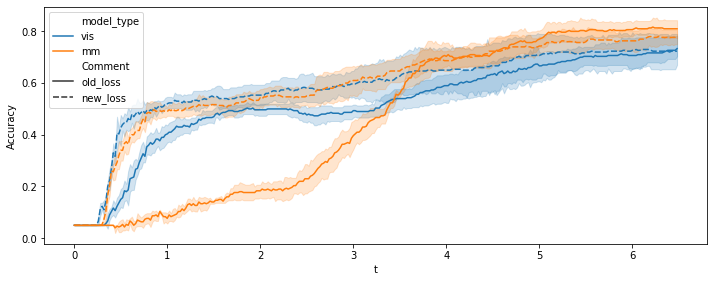

In [23]:
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x='t', y='Accuracy', hue='model_type', data = df, style='Comment')
plt.tight_layout(True)
#fig.savefig('ParabolaRes.png')
plt.show()